# PyTorch Training and using checkpointing on SageMaker Managed Spot Training
The example here is almost the same as [PyTorch Cifar10 local training](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/pytorch_cnn_cifar10/pytorch_local_mode_cifar10.ipynb).

This notebook tackles the exact same problem with the same solution, but it has been modified to be able to run using SageMaker Managed Spot infrastructure. SageMaker Managed Spot uses [EC2 Spot Instances](https://aws.amazon.com/ec2/spot/) to run Training at a lower cost.

Please read the original notebook and try it out to gain an understanding of the ML use-case and how it is being solved. We will not delve into that here in this notebook.

## Overview

The **SageMaker Python SDK** helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow, MXNet, PyTorch and Chainer. This tutorial focuses on how to create a convolutional neural network model to train the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using **PyTorch in local mode**.

### Set up the environment

This notebook was created and tested on a single ml.p2.xlarge notebook instance.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [1]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = 'dl-vision-yasd-course' #sagemaker_session.default_bucket()
prefix = 'hw02'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/{}-checkpoint-{}'.format(bucket, prefix, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.86.2
Checkpointing Path: s3://dl-vision-yasd-course/hw02-checkpoint-59e650dc


In [2]:
import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

Sat May 21 00:15:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download the Cifar10 dataset

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms


data_path = '.'
imagenet_dir = os.path.join(data_path, 'tiny-imagenet-200')
dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/train', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])
test_dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/test', transform=transforms.ToTensor())

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=128,
                                              shuffle=True,
                                              num_workers=1)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=128,
                                              shuffle=True,
                                              num_workers=1)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=128,
                                              shuffle=True,
                                              num_workers=1)

Matplotlib is building the font cache; this may take a moment.


### Data Preview

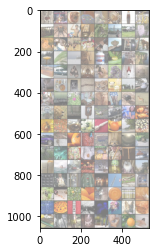

In [4]:
# get some random training images
dataiter = iter(train_batch_gen)
images, labels = dataiter.next()

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
#print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [ ]:
#inputs = sagemaker_session.upload_data(path='tiny-imagenet-200', bucket=bucket, key_prefix='data/input')

# Construct a script for training 
Here is the full code for the network model:

## Script Functions

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the model_fn() is called to determine how to load your trained model. The model_fn() along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* model_fn(model_dir) - loads your model.
* input_fn(serialized_input_data, content_type) - deserializes predictions to predict_fn.
* output_fn(prediction_output, accept) - serializes predictions from predict_fn.
* predict_fn(input_data, model) - calls a model on data deserialized in input_fn.

The model_fn() is the only function that doesn't have a default implementation and is required by the user for using PyTorch on SageMaker. 

## Create a training job using the sagemaker.PyTorch estimator

The `PyTorch` class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. For local training with GPU, we could set this to "local_gpu".  In this case, `instance_type` was set above based on your whether you're running a GPU instance.

After we've constructed our `PyTorch` object, we fit it using the data we uploaded to S3. Even though we're in local mode, using S3 as our data source makes sense because it maintains consistency with how SageMaker's distributed, managed training ingests data.


In [2]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 15}

use_spot_instances = False
max_run = 60 * 60 # 60 min
max_wait = 1200 if use_spot_instances else None


estimator = PyTorch(entry_point='net.py',
                            role=role,
                            framework_version='1.10.0',
                            py_version='py38',
                            instance_count=1,
                            instance_type='ml.g4dn.xlarge',
                            base_job_name='tiny-imagenet-pytorch-1',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            input_mode='FastFile',
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)


estimator.fit({
        'train': 's3://{}/data/input/train'.format(bucket),
        'val': 's3://{}/data/input/val'.format(bucket)
    }, 
    wait=False
)
print('started training')

started training


# Managed Spot Training with a PyTorch Estimator

For Managed Spot Training using a PyTorch Estimator we need to configure two things:
1. Enable the `train_use_spot_instances` constructor arg - a simple self-explanatory boolean.
2. Set the `train_max_wait` constructor arg - this is an int arg representing the amount of time you are willing to wait for Spot infrastructure to become available. Some instance types are harder to get at Spot prices and you may have to wait longer. You are not charged for time spent waiting for Spot infrastructure to become available, you're only charged for actual compute time spent once Spot instances have been successfully procured.

Normally, a third requirement would also be necessary here - modifying your code to ensure a regular checkpointing cadence - however, PyTorch Estimators already do this, so no changes are necessary here. Checkpointing is highly recommended for Manage Spot Training jobs due to the fact that Spot instances can be interrupted with short notice and using checkpoints to resume from the last interruption ensures you don't lose any progress made before the interruption.

Feel free to toggle the `use_spot_instances` variable to see the effect of running the same job using regular (a.k.a. "On Demand") infrastructure.

Note that `max_wait` can be set if and only if `use_spot_instances` is enabled and **must** be greater than or equal to `max_run`.

In [ ]:
use_spot_instances = True
max_run=600
max_wait = 1200 if use_spot_instances else None

## Simulating Spot interruption after 5 epochs

Our training job should run on 10 epochs.

However, we will simulate a situation that after 5 epochs a spot interruption occurred.

The goal is that the checkpointing data will be copied to S3, so when there is a spot capacity available again, the training job can resume from the 6th epoch.

Note the `checkpoint_s3_uri` variable which stores the S3 URI in which to persist checkpoints that the algorithm persists (if any) during training.

The `debugger_hook_config` parameter must be set to `False` to enable checkpoints to be copied to S3 successfully.

In [ ]:
hyperparameters = {'epochs': 5}


spot_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch-spot-1',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)

spot_estimator.fit(inputs)

### Savings
Towards the end of the job you should see two lines of output printed:

- `Training seconds: X` : This is the actual compute-time your training job spent
- `Billable seconds: Y` : This is the time you will be billed for after Spot discounting is applied.

If you enabled the `use_spot_instances` var then you should see a notable difference between `X` and `Y` signifying the cost savings you will get for having chosen Managed Spot Training. This should be reflected in an additional line:
- `Managed Spot Training savings: (1-Y/X)*100 %`

### View the job training Checkpoint configuration
We can now view the Checkpoint configuration from the training job directly in the SageMaker console.

Log into the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), choose the latest training job, and scroll down to the Checkpoint configuration section. 

Choose the S3 output path link and you'll be directed to the S3 bucket were checkpointing data is saved.

You can see there is one file there:

```python
checkpoint.pth
```

This is the checkpoint file that contains the epoch, model state dict, optimizer state dict, and loss.

### Continue training after Spot capacity is resumed

Now we simulate a situation where Spot capacity is resumed.

We will start a training job again, this time with 10 epochs.

What we expect is that the tarining job will start from the 6th epoch.

This is done when training job starts. It checks the checkpoint s3 location for checkpoints data. If there are, they are copied to `/opt/ml/checkpoints` on the training conatiner.

In the code you can see the function to load the checkpoints data:

```python
def _load_checkpoint(model, optimizer, args):
    print("--------------------------------------------")
    print("Checkpoint file found!")
    print("Loading Checkpoint From: {}".format(args.checkpoint_path + '/checkpoint.pth'))
    checkpoint = torch.load(args.checkpoint_path + '/checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_number = checkpoint['epoch']
    loss = checkpoint['loss']
    print("Checkpoint File Loaded - epoch_number: {} - loss: {}".format(epoch_number, loss))
    print('Resuming training from epoch: {}'.format(epoch_number+1))
    print("--------------------------------------------")
    return model, optimizer, epoch_number
```


In [ ]:
hyperparameters = {'epochs': 10}


spot_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch-spot-2',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)

spot_estimator.fit(inputs)

### Analyze training job logs

Analyzing the training job logs, we can see that now, the training job starts from the 6th epoch.

We can see the output of `_load_checkpoint` function:

```
--------------------------------------------
Checkpoint file found!
Loading Checkpoint From: /opt/ml/checkpoints/checkpoint.pth
Checkpoint File Loaded - epoch_number: 5 - loss: 0.8455273509025574
Resuming training from epoch: 6
--------------------------------------------
```

### View the job training Checkpoint configuration after job completed 10 epochs

We can now view the Checkpoint configuration from the training job directly in the SageMaker console.  

Log into the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), choose the latest training job, and scroll down to the Checkpoint configuration section. 

Choose the S3 output path link and you'll be directed to the S3 bucket were checkpointing data is saved.

You can see there is still that one file there:

```python
checkpoint.pth
```

You'll be able to see that the date of the checkpoint file was updated to the time of the 2nd Spot training job.

# Deploy the trained model to prepare for predictions

The deploy() method creates an endpoint which serves prediction requests in real-time.

In [ ]:
from sagemaker.pytorch import PyTorchModel

predictor = spot_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# Invoking the endpoint

In [ ]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                              for j in range(4)))

# Clean-up

To avoid incurring extra charges to your AWS account, let's delete the endpoint we created:

In [ ]:
predictor.delete_endpoint()